In [218]:
# Library Imports

import sys
import numpy as np
from scipy.stats import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Collection:

In [219]:
#Data importation
df = pd.read_csv(
    '/content/household_power_consumption.txt',
    sep=";",
    na_values=["?", "NA", ""],
    low_memory=False
)

df.head(), df.shape

(         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
 0  16/12/2006  17:24:00                4.216                  0.418   234.84   
 1  16/12/2006  17:25:00                5.360                  0.436   233.63   
 2  16/12/2006  17:26:00                5.374                  0.498   233.29   
 3  16/12/2006  17:27:00                5.388                  0.502   233.74   
 4  16/12/2006  17:28:00                3.666                  0.528   235.68   
 
    Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
 0              18.4             0.0             1.0            17.0  
 1              23.0             0.0             1.0            16.0  
 2              23.0             0.0             2.0            17.0  
 3              23.0             0.0             1.0            17.0  
 4              15.8             0.0             1.0            17.0  ,
 (2075259, 9))

Once the data was loaded, the head() function was invoked to check out the first rows of the data set to ensure the file was read properly and all the variables were properly structured. The shape property was then applied on the dataset dimensions which proved that it (2075259, 9) observations that are dealing with electrical consumption, voltage and sub-metering measurements.

In [220]:
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [221]:
df.shape


(2075259, 9)

# Clean the data by handling missing values and any duplicates

Missing data analysis was conducted to analyze the quality of data and the variables that needed to be preprocessed before modeling.
To begin with, the number of missing values in each column was first calculated using the isnull().sum() function. Then the percentage of missing data as compared to the overall size of the dataset was calculated to determine the effects. These values were summarized into one table that shows the number and the percentage of missing values of each variable.
It was found that there are few important variables such as Global_active power, Global reactive power, Voltage, Global intensity, the three sub-metering variables in which some observations are missing. All these variables contain equal amounts of missing (25,979) which is about 1.25 percent of the data.
Even though the percentage of missing data is not very wide, it is rather considerable and needs to be processed accordingly to prevent the bias or loss of information when training the model. This will be necessary in taking care of data reliability and will set the stage to undergo further cleaning and imputation process.


In [222]:
print(f"Total missing values before handling: {df.isnull().sum().sum()}")


Total missing values before handling: 181853


In [223]:
# Check for missing values
print("\n[2.1] Missing Values Analysis:")
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_percentages
})
print(missing_df[missing_df['Missing Count'] > 0])


[2.1] Missing Values Analysis:
                       Missing Count  Percentage
Global_active_power            25979    1.251844
Global_reactive_power          25979    1.251844
Voltage                        25979    1.251844
Global_intensity               25979    1.251844
Sub_metering_1                 25979    1.251844
Sub_metering_2                 25979    1.251844
Sub_metering_3                 25979    1.251844


# Convert the data into a format suitable for time-series analysis

First,the seperated Date and Time columns were merged and turned into a single datetime variable to allow time-series analysis of the data. It was done through the use of the pd.to_datetime function that converts the date and time values based on the defined format (day/month/year hour:minute:second).
Secondly for row containing invalid datetime were then deleted to ensure the table had a clean and reliable temporal structure.Then,the DateTime variable created was next assigned the DataFrame index.Lastly, original Date and Time columns were deleted. This will reduce the size of the dataset and eliminate redundant variables.On the whole, this transformation provides a stable time frame that is needed to make accurate time-based analysis and modelling.
Lastly, all the rest of the variables were translated into the numerical form so that they could be compatible with the machine learning models.


In [224]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                 format='%d/%m/%Y %H:%M:%S',
                                 errors='coerce')


In [225]:
# Remove rows with invalid datetime
df = df.dropna(subset=['DateTime'])



In [226]:
# Set DateTime as index
df.set_index('DateTime', inplace=True)



In [227]:
# Drop original Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

All variables were converted to numeric format to make compatible with machine learning models . Coercion strategy was used to perform the conversion where all non-numeric or invalid values are converted into missing values.

In [228]:
numeric_columns = df.columns
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Data types after conversion:")
print(df.dtypes)

Data types after conversion:
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [229]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In order to deal with missing values without altering the temporal structure nature of the dataset, a multi-step imputation plan was used.
To begin with, one copy of the initial dataset was made so that the original raw data were not changed by the preprocessing process. Then a forward fill algorithm was used to fill in short gaps with the latest valid observation. This is based on the belief that values do not change much within short periods of time. A maximum consecutive observation count of 60 was placed to avoid the unrealistic values propagation due to long missing intervals.
After forward filling, backward filling was used to handle any remaining short gaps. This method replaces missing values using the next available observation, which is particularly useful for gaps occurring at the beginning of a sequence where forward fill cannot be applied.
Linear interpolation was then done on any additional missing values.
This imputation approach is progressive so that the small gaps will be filled with realistic observed values, whereas larger gaps will be estimated with the help of statistics. This consequently leaves the dataset consistent, continuous and time-series modelable.


In [230]:
df_filled = df.copy()


In [231]:
# First, try forward fill (limit to 60 minutes)

df_filled = df_filled.ffill(limit=60)


In [232]:
# Then backward fill for remaining

df_filled = df_filled.bfill(limit=60)


In [233]:
# For any remaining, use linear interpolation

df_filled = df_filled.interpolate(method='linear', limit_direction='both')


In [234]:
# Drop any remaining rows with missing values (should be very few)
initial_rows = len(df_filled)
df_filled = df_filled.dropna()
rows_dropped = initial_rows - len(df_filled)

print(f"Rows dropped after all filling strategies: {rows_dropped}")
print(f"Remaining missing values: {df_filled.isnull().sum().sum()}")


Rows dropped after all filling strategies: 0
Remaining missing values: 0


In order to maintain the integrity of the time-series structure, the dataset was inspected of duplicate timestamps in the datetime index. Redundant time entries may cause a wrong aggregation, biased statistics, and untrustworthy model training.
The index.duplicated() was used to calculate the number of duplicated timestamps. In the case that some duplicates were found then only the first instance of each stamp would be retained and the other duplicates would be deleted. This guarantees that the points of time are distinctly represented in the dataset.
The findings indicated that the dataset did not contain duplicate timestamps, meaning that the time index is clean and well-organized to be used in the further analysis and modelling of time-series.


In [235]:
# Remove duplicates
duplicates = df_filled.index.duplicated().sum()
print(f"Duplicate timestamps found: {duplicates}")
if duplicates > 0:
    df_filled = df_filled[~df_filled.index.duplicated(keep='first')]
    print(f"Duplicates removed. New shape: {df_filled.shape}")

Duplicate timestamps found: 0


# Resample the data to a more appropriate frequency

The time-series data was resampled to hourly frequency to reduce the size of the data and enhance the efficiency of the analytical process. It was done with the resample(h).mean operation, which moves all the observations in each hour and averages the values.
Resampling greatly allows the reduction of the dataset and thus more efficient computations coupled with removal of short-periodic variations and measurement errors. Simultaneously, hourly aggregation maintains substantial consumption patterns, including daily consumption cycles and behavioral patterns.Following resampling, an hourly dataset, which was clean, was obtained to form the working dataset to be used in modelling. This guarantees that further feature engineering and machine learning processes will be done on an ordered, aggregated and analysis-ready time series.


In [236]:
#Resample to hourly averages
df_hourly = df_filled.resample('h').mean()

print(f"Original data points: {len(df_filled)}")
print(f"After hourly resampling: {len(df_hourly)}")
print(f"Date range: {df_hourly.index.min()} to {df_hourly.index.max()}")


Original data points: 2075259
After hourly resampling: 34589
Date range: 2006-12-16 17:00:00 to 2010-11-26 21:00:00


# Perform feature engineering

In [237]:
#Create a clean dataframe for modeling
df_model = df_hourly.copy()

To obtain time trends in electricity consumption, time characteristics were derived based on the index of date.These include the hour of the day, day of the week, day of the month, month, quarter and year.
These variables are useful in the learning of the model by the daily cycles, weekly behavior, seasonal variations, and the long-term trends.


In [238]:
# Time-based features
df_model['hour'] = df_model.index.hour
df_model['day_of_week'] = df_model.index.dayofweek  # 0=Monday, 6=Sunday
df_model['day_of_month'] = df_model.index.day
df_model['month'] = df_model.index.month
df_model['quarter'] = df_model.index.quarter
df_model['year'] = df_model.index.year

In [239]:
df_model

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,day_of_month,month,quarter,year
DateTime,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,16,12,4,2006
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,16,12,4,2006
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,16,12,4,2006
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,16,12,4,2006
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,16,12,4,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,17,4,26,11,4,2010
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,18,4,26,11,4,2010
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,19,4,26,11,4,2010


In order to increase predictive power of the model, several elements of time and behavior derived of the datetime index were used.
Cyclical Encoding:
Since the time variables as hour, day of the week and month are recurrent in nature, sine and cosine transformations were incorporated to preserve the periodic character of these variables. This prevents artificial discontinuities (e.g. 23: 00 numerically distant 00:00) and allows the model to better learn the recurrent temporal patterns.
Binary Behavioral Features
Two binary measures were developed that reflected variations in household patterns of energy consumption as a result of time-based behavior.
The indicator of the weekend (isweekend) determines whether an observation is made on a weekend (Saturday or Sunday).
The night feature (isnight) determines hours that are usually characterized by low or alternative activity in the household (between 8 PM and 6 AM). This assists the model to isolate the nighttime patterns of consumption and daytime consumption.
The binary features enable the model to explain the differences in behavioral characteristics of energy consumption depending on the weekly schedules and daily activity cycles.
Historical Power Features (Lagged Variables)
The historical power features were obtained by using previous values of Globalactivepower in order to obtain the temporal dependence of electricity consumption. These variables are consumption at various time levels in the past (1, 2, 3, 6, 12 and 24 hours before the present time).
Having these historical measures, the model gets an access to recent trends in consumption which is usually highly correlated to the present energy consumption.


In [240]:
# Cyclical encoding for hour (captures cyclical nature of time)
df_model['hour_sin'] = np.sin(2 * np.pi * df_model['hour'] / 24)
df_model['hour_cos'] = np.cos(2 * np.pi * df_model['hour'] / 24)

# Cyclical encoding for day of week
df_model['day_sin'] = np.sin(2 * np.pi * df_model['day_of_week'] / 7)
df_model['day_cos'] = np.cos(2 * np.pi * df_model['day_of_week'] / 7)

# Cyclical encoding for month
df_model['month_sin'] = np.sin(2 * np.pi * df_model['month'] / 12)
df_model['month_cos'] = np.cos(2 * np.pi * df_model['month'] / 12)

# Binary features
df_model['is_weekend'] = (df_model['day_of_week'] >= 5).astype(int)
df_model['is_night'] = ((df_model['hour'] >= 20) | (df_model['hour'] <= 6)).astype(int)

# Lagged features (previous hours' consumption)
for lag in [1, 2, 3, 6, 12, 24]:
    df_model[f'historical_power_{lag}h'] = df_model['Global_active_power'].shift(lag)

In [241]:
df_model

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,day_of_month,...,month_sin,month_cos,is_weekend,is_night,historical_power_1h,historical_power_2h,historical_power_3h,historical_power_6h,historical_power_12h,historical_power_24h
DateTime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,16,...,-2.449294e-16,1.000000,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,16,...,-2.449294e-16,1.000000,1,0,4.222889,NaN,NaN,NaN,NaN,NaN
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,16,...,-2.449294e-16,1.000000,1,0,3.632200,4.222889,NaN,NaN,NaN,NaN
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,16,...,-2.449294e-16,1.000000,1,1,3.400233,3.632200,4.222889,NaN,NaN,NaN
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,16,...,-2.449294e-16,1.000000,1,1,3.268567,3.400233,3.632200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,17,4,26,...,-5.000000e-01,0.866025,0,0,1.067933,0.876433,1.407767,1.338900,0.282567,1.480100
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,18,4,26,...,-5.000000e-01,0.866025,0,0,1.725900,1.067933,0.876433,1.490200,1.008767,2.211600
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,19,4,26,...,-5.000000e-01,0.866025,0,0,1.573467,1.725900,1.067933,1.612933,2.883933,2.330467


In [242]:
df_model = df_model.dropna()

In [243]:
# Rolling statistics
#df_model['rolling_mean_24h'] = df_model['Global_active_power'].rolling(window=24, min_periods=1).mean()
#df_model['rolling_std_24h'] = df_model['Global_active_power'].rolling(window=24, min_periods=1).std()

# Drop rows with NaN from lagged features
#df_model = df_model.dropna()



# EXPLORATORY DATA ANALYSIS


In [244]:
#Basic Statistics
print(df_hourly[['Global_active_power', 'Voltage', 'Global_intensity']].describe())

       Global_active_power       Voltage  Global_intensity
count         34589.000000  34589.000000      34589.000000
mean              1.090275    240.832827          4.621469
std               0.894360      3.001629          3.743735
min               0.124000    225.834500          0.503333
25%               0.342867    239.178167          1.516667
50%               0.803100    240.974667          3.423333
75%               1.578700    242.689333          6.603333
max               6.560533    251.902000         28.383333


This figure depicts the trend of household global active power consumption summed up at an hourly level. The time series indicates that there is a significant change in electricity consumption with frequent changes in the short term and sometimes high peaks of consumption.
Obvious time trends have been observed, indicating that there are seasonal and behavioural effects on energy demand.


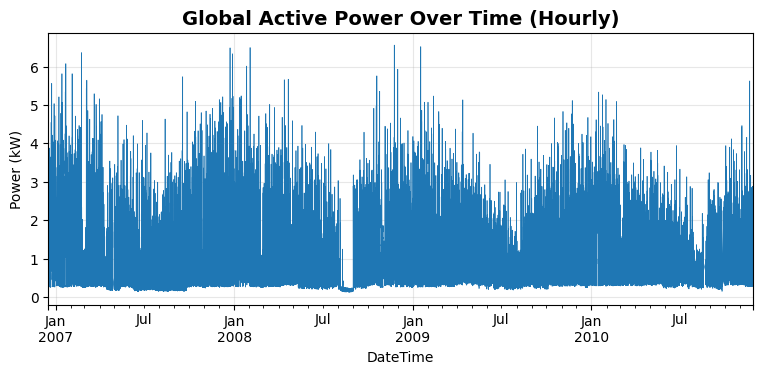

In [245]:
# Plot  1: Time series of global active power

fig = plt.figure(figsize=(20, 12))

ax1 = plt.subplot(3, 2, 1)
df_hourly['Global_active_power'].plot(ax=ax1, linewidth=0.5)
plt.title('Global Active Power Over Time (Hourly)', fontsize=14, fontweight='bold')
plt.ylabel('Power (kW)')
plt.xlabel('DateTime')
plt.grid(True, alpha=0.3)

This figure shows the rate of electricity usage per hour of the day, and it is evident that there are definite patterns in the everyday use of electricity. The consumption is the lowest in late night and early mornings hours when the household activity is low.
The use of energy grows in the morning with the onset of activities in a day, is moderate during the day and peaks in the evening. Such evening peak is probably an indication of common household activities, including cooking, illumination, and use of appliances after the residents have gone back home.


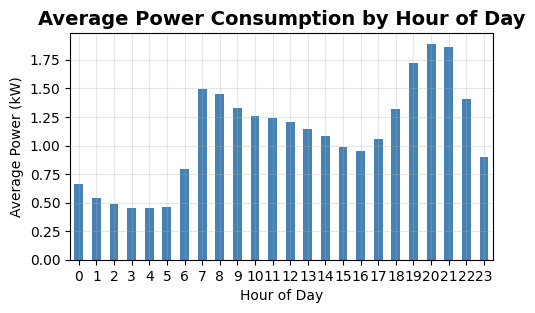

In [246]:
#Plot 2: Daily average pattern

plt.figure(figsize=(12, 10))

ax2 = plt.subplot(3, 2, 2)
hourly_pattern = df_model.groupby('hour')['Global_active_power'].mean()
hourly_pattern.plot(kind='bar', ax=ax2, color='steelblue')
plt.title('Average Power Consumption by Hour of Day', fontsize=14, fontweight='bold')
plt.ylabel('Average Power (kW)')
plt.xlabel('Hour of Day')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

This figure displays the average daily electric usage per day of the week. The consumption levels are rather constant throughout the weekdays with slight differences on Monday and Friday.
There is an increase in the average consumption during weekends especially on Saturdays and Sundays. This growth will probably be because there is increased activity in the household since more time is spent at home than working days


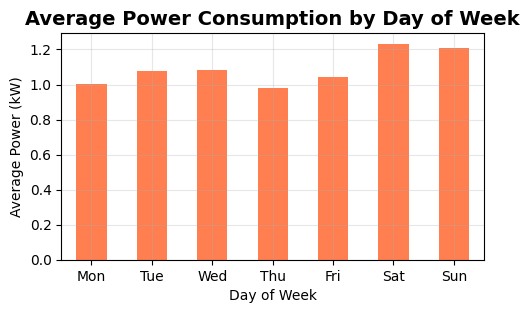

In [247]:
# Plot 3: Weekly pattern

plt.figure(figsize=(12, 10))

ax3 = plt.subplot(3, 2, 3)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_pattern = df_model.groupby('day_of_week')['Global_active_power'].mean()
weekly_pattern.plot(kind='bar', ax=ax3, color='coral')

plt.title('Average Power Consumption by Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Average Power (kW)')
plt.xlabel('Day of Week')
plt.xticks(range(7), days, rotation=0)
plt.grid(True, alpha=0.3)


This figure shows the average of electricity consumed every single month of the year, and it can be stated that there is a certain seasonal trend. The maximum consumption is during winter seasons especially in the months of December and January and gradually decreases towards the summer season.
The minimal consumption rates are in mid-summer particularly in July and August and again increases in autumn and early winter. This seasonal change probably depicts the use of more energy to heat during cooler seasons and the use of less energy in the warmer seasons.


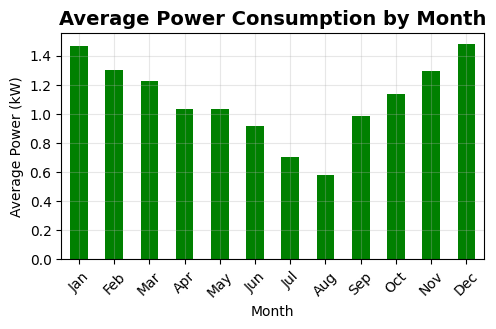

In [248]:
# Plot 4: Monthly pattern

plt.figure(figsize=(12, 10))

ax4 = plt.subplot(3, 2, 4)
monthly_pattern = df_model.groupby('month')['Global_active_power'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_pattern.plot(kind='bar', ax=ax4, color='green')
plt.title('Average Power Consumption by Month', fontsize=14, fontweight='bold')
plt.ylabel('Average Power (kW)')
plt.xlabel('Month')
plt.xticks(range(12), months, rotation=45)
plt.grid(True, alpha=0.3)

This histogram represents the distribution of the household global active power consumption. The highest concentrations of observations are at lower power levels with most of the time electricity usage remains relatively moderate.
This distribution is positively skewed and the tail extends through high powers. It implies that high consumption is less frequent, but when the consumption occurs it establishes occasional peaks in energy demand, presumably due to periods of high activity in the household


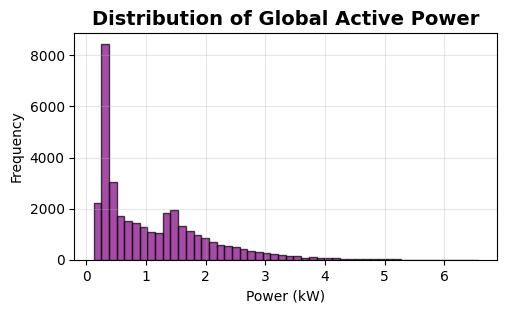

In [249]:
#Distribution

plt.figure(figsize=(12, 10))

ax5 = plt.subplot(3, 2, 5)
df_hourly['Global_active_power'].hist(bins=50, ax=ax5, color='purple', alpha=0.7, edgecolor='black')
plt.title('Distribution of Global Active Power', fontsize=14, fontweight='bold')
plt.ylabel('Frequency')
plt.xlabel('Power (kW)')
plt.grid(True, alpha=0.3)


This box plot illustrates the way that electricity consumption changes with time of the day. The levels of consumption in general are low and relatively steady in the late-night and early-morning hours. The median consumption and variability values rise as the daily activities, especially in the daytime and evening hours.
The peak consumption rates and the most variation are observed during the evening, and it is the time of the high household activity. There are also many outliers, which suggests that there are instances of uncharacteristically high energy consumption.


EDA plots saved: eda_plots.png


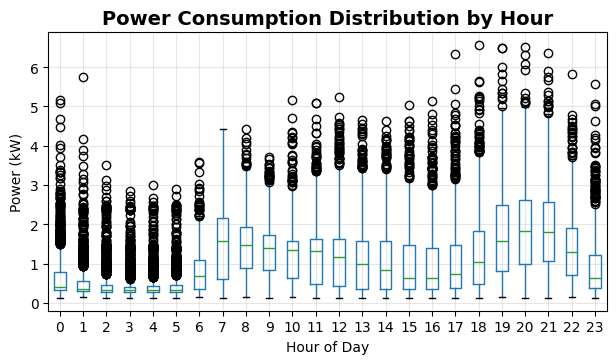

In [250]:
##Plot 6: Box plot by hour

plt.figure(figsize=(12, 10))

ax6 = plt.subplot(3, 2, 6)
df_model.boxplot(column='Global_active_power', by='hour', ax=ax6)

plt.title('Power Consumption Distribution by Hour', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.ylabel('Power (kW)')
plt.xlabel('Hour of Day')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=300, bbox_inches='tight')

print("EDA plots saved: eda_plots.png")


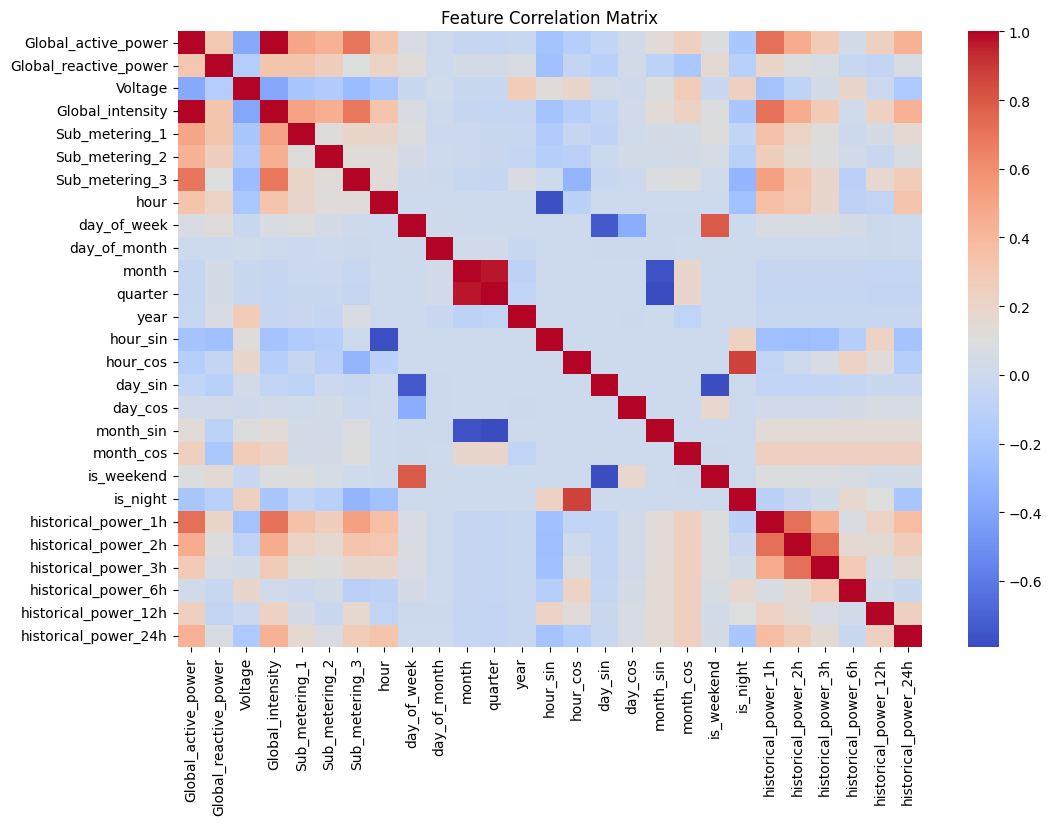

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df_model.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


# MODEL PREPARATION


In [ ]:
Global_active_power, which is an indicator of the power used in the household, was considered the target variable to be predicted.
The rest of the relevant variables were then chosen to be input features.The features that have been chosen are time-based variables, the cyclical encodings, binary indicators, historical consumption values, and rolling statistics.


In [252]:
# Target variable
target = 'Global_active_power'

In [253]:
# Feature columns
feature_cols = [col for col in df_model.columns if col not in [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]]

print(f"Target variable: {target}")
print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")


Target variable: Global_active_power
Number of features: 20
Features: ['hour', 'day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_night', 'historical_power_1h', 'historical_power_2h', 'historical_power_3h', 'historical_power_6h', 'historical_power_12h', 'historical_power_24h']


The data was split into training and testing to test the performance of the models on unknown data. The input variables (X) and target variable (y) had first been specified and the data divided into an 80/20 ratio.
As it is time-series data, shuffling was off to maintain the order in time. This makes the model be trained on historical data and tested on emerging data to avoid data leakage.
To report and analyze data, the initial dataset was also divided using the same boundary to get the respective training and testing time periods.Train–Test Data Splitting


In [254]:
from sklearn.model_selection import train_test_split

# Prepare features and target
X = df_model[feature_cols]
y = df_model[target]

# Train_test_split with shuffle=False to maintain temporal order
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for testing
    shuffle=False,
    random_state=42
)

In [255]:
# Get the actual data splits for reporting
train_data = df_model.iloc[:len(X_train)]
test_data = df_model.iloc[len(X_train):]

In [256]:
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import Ridge

#ridge_pipeline = Pipeline([
 #   ('scaler', StandardScaler()),
  #  ('model', Ridge())
#])


In [257]:
#rf_pipeline = Pipeline([
#    ('model', RandomForestRegressor(
 #       n_estimators=200,
  #      max_depth=20,
   #     random_state=42,
    #    n_jobs=-1
    #))
#])

TimeSeriesSplit was used to implement time-series cross-validation to maintain the temporal order and to model the realistic evaluation. RMSE, MAE, and R 2 measures were used to determine model performance, complementary to each other to measure prediction accuracy and explanatory power.

In [259]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)

In [260]:
#Evaluation function

def evaluate(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}


Three machine learning regression algorithms were chosen to predict the electricity usage of households: Random Forest, Gradient Boosting and Ridge Regression.

* Random Forest Regressor
Random Forest is an ideal choice in time-series forecasting to use in situations where historical and engineered variables are available. It is resistant to noise and it is capable of modeling complex interactions among variables without strong assumptions on data distribution.

* Gradient Boosting Regressor.
Gradient Boosting tends to be very accurate in prediction since it dwells on cases that are hard to predict. It works well with structured data and is able to detect finer nonlinear patterns in energy consumption.

* Ridge Regression
Ridge is a good linear baseline model and it works well where predictors are highly correlated as seen with time-series features like lagged and rolling variables. Both regularization and generalization are enhanced.


In [261]:
#Before tuning

before_tuning_models = {}

# Random Forest
before_tuning_models["RF_before_tuning"] = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Gradient Boosting
before_tuning_models["GB_before_tuning"] = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# Ridge
before_tuning_models["Ridge_before_tuning"] = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

To evaluate the three models RMSE, MAE, and R² metrics was used
Both Random Forest and Gradient Boosting achieved similar performance levels, with lower error values and higher R² compared to Ridge Regression. This indicates that tree-based ensemble models are more effective at capturing the nonlinear relationships and complex patterns present in electricity consumption data.
Ridge Regression showed slightly higher prediction errors and a lower R² score, suggesting that a purely linear model is less capable of modeling the temporal dependencies and nonlinear dynamics of power consumption.


In [262]:
# Entraînement + évaluation des baselines

before_tuning_results = []
before_tuning_predictions = {}

for name, model in before_tuning_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    before_tuning_predictions[name] = y_pred
    before_tuning_results.append(evaluate(y_test, y_pred, name))

before_tuning_results_df = pd.DataFrame(before_tuning_results).sort_values("RMSE")
before_tuning_results_df


,Model,RMSE,MAE,R2
0,RF_before_tuning,0.475331,0.334504,0.574148
1,GB_before_tuning,0.475353,0.334761,0.574107
2,Ridge_before_tuning,0.512097,0.363848,0.505720


## Hyperparameter Optimization

In order to enhance the performance, the hyperparameter optimization was done by use of GridSearchCV. Each model was tested using a predefined combination of parameter settings. To ensure chronological consistency in tuning, TimeSeriesSplit cross-validation was employed to ensure that the models were always trained on past data and tested on future data.converted to RMSE for interpretability.


In [263]:
#####GridSearch#############

# 1) RF Grid
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [15, 20, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 2) GB Grid
gb = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0]
}
gb_grid = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 3) Ridge Grid
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])
ridge_param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(
    ridge_pipe, ridge_param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_searches = {
    "RF_optimized": rf_grid,
    "GB_optimized": gb_grid,
    "Ridge_optimized": ridge_grid
}


In [264]:
# Training + GridSearch

after_tuning_results = []
after_tuning_predictions = {}
best_params = {}

for name, grid in grid_searches.items():
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params[name] = grid.best_params_

    y_pred = best_model.predict(X_test)
    after_tuning_predictions[name] = y_pred
    after_tuning_results.append(evaluate(y_test, y_pred, name))

after_tuning_results_df = pd.DataFrame(after_tuning_results).sort_values("RMSE")
after_tuning_results_df


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,RMSE,MAE,R2
0,RF_optimized,0.467349,0.323052,0.588329
1,GB_optimized,0.468467,0.326365,0.586357
2,Ridge_optimized,0.511912,0.363858,0.506077


In [265]:
# before_tuning vs after_tuning

final_df = pd.concat(
    [
        before_tuning_results_df.assign(Phase="before_tuning"),
        after_tuning_results_df.assign(Phase="after_tuning")
    ],
    ignore_index=True
).sort_values(["RMSE", "Phase"])

final_df


,Model,RMSE,MAE,R2,Phase
3,RF_optimized,0.467349,0.323052,0.588329,after_tuning
4,GB_optimized,0.468467,0.326365,0.586357,after_tuning
0,RF_before_tuning,0.475331,0.334504,0.574148,before_tuning
1,GB_before_tuning,0.475353,0.334761,0.574107,before_tuning
5,Ridge_optimized,0.511912,0.363858,0.506077,after_tuning
2,Ridge_before_tuning,0.512097,0.363848,0.505720,before_tuning


In [266]:
# best params

best_params


{'RF_optimized': {'max_depth': 15,
  'min_samples_leaf': 6,
  'min_samples_split': 15,
  'n_estimators': 150},
 'GB_optimized': {'learning_rate': 0.05,
  'max_depth': 5,
  'n_estimators': 100,
  'subsample': 0.8},
 'Ridge_optimized': {'model__alpha': 100}}

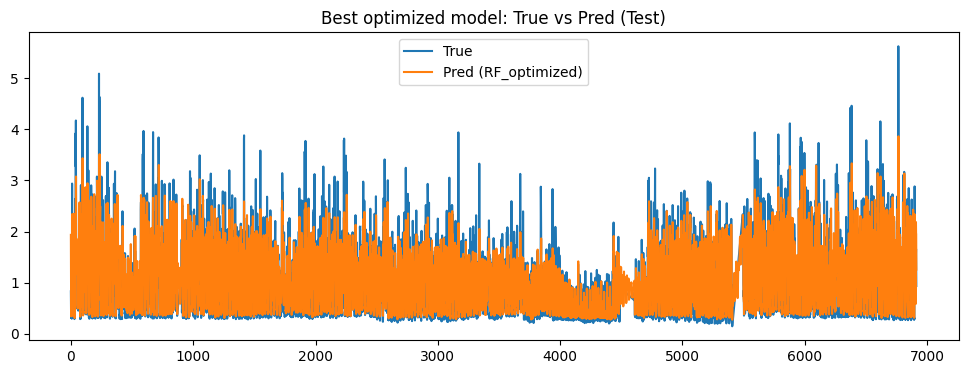

In [267]:
# Plot best models

best_name = after_tuning_results_df.iloc[0]["Model"]
best_pred = after_tuning_predictions[best_name]

plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="True")
plt.plot(best_pred, label=f"Pred ({best_name})")
plt.title("Best optimized model: True vs Pred (Test)")
plt.legend()
plt.show()


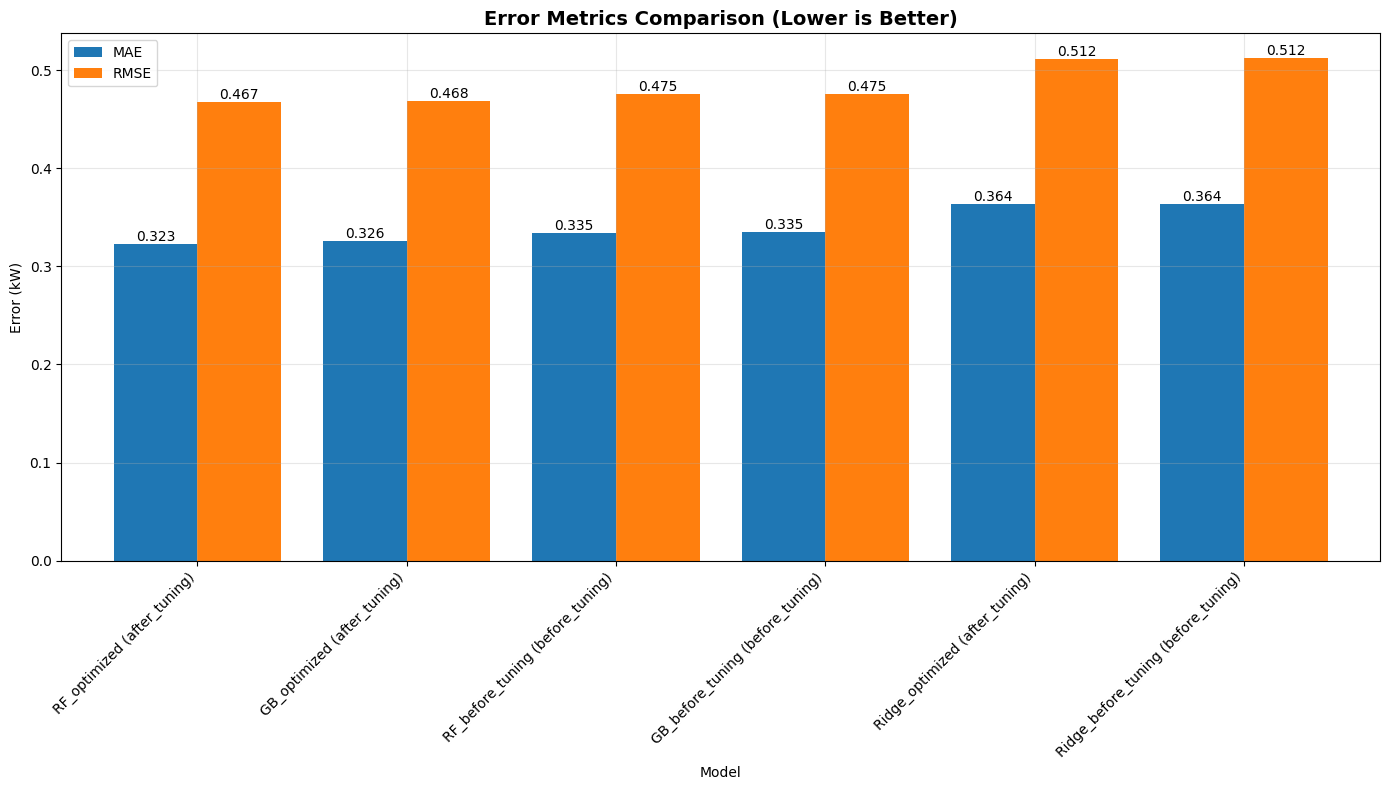

In [268]:

plot_df = final_df.sort_values("RMSE")

fig = plt.figure(figsize=(14, 8))

ax1 = plt.subplot(1, 1, 1)


plot_df["Model_Label"] = plot_df["Model"] + " (" + plot_df["Phase"] + ")"

# Plot
plot_df.set_index("Model_Label")[["MAE", "RMSE"]].plot(
    kind="bar",
    ax=ax1,
    width=0.8
)

plt.title("Error Metrics Comparison (Lower is Better)", fontsize=14, fontweight="bold")
plt.ylabel("Error (kW)")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)

for container in ax1.containers:
    ax1.bar_label(container, fmt="%.3f")

plt.tight_layout()
plt.show()


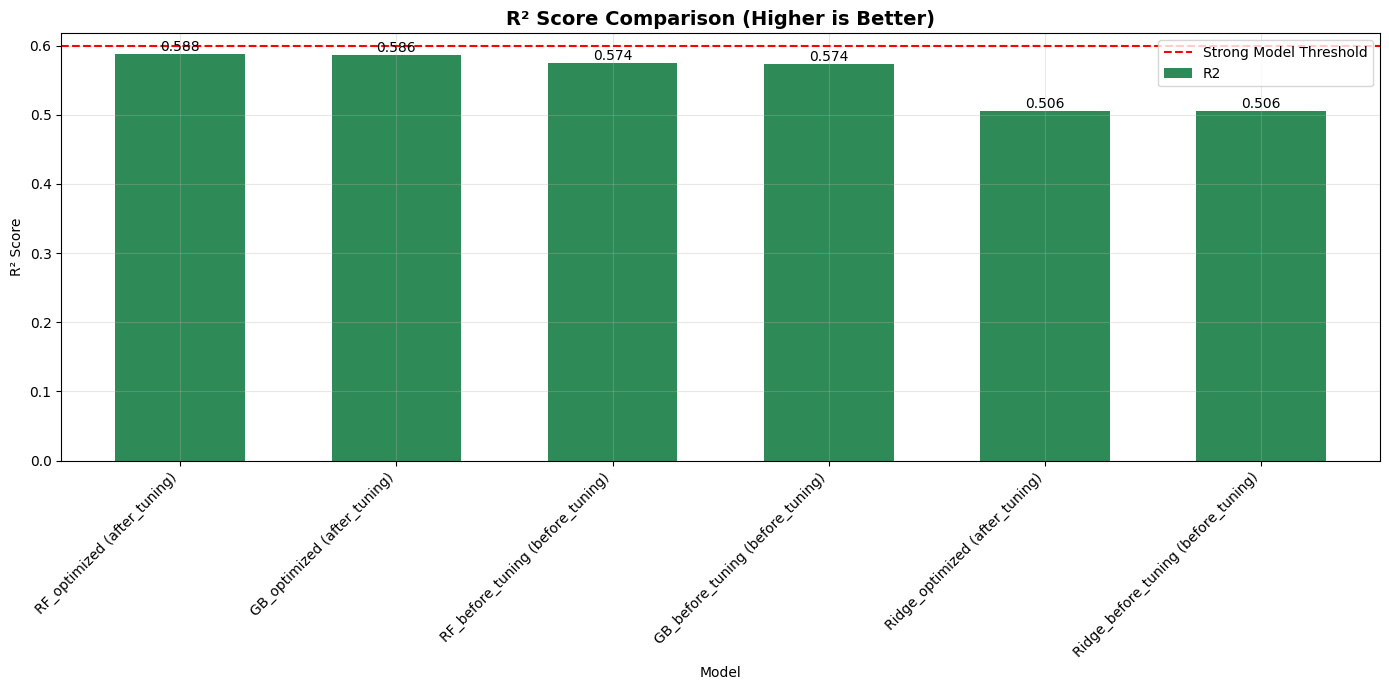

In [269]:
import matplotlib.pyplot as plt

plot_df = final_df.sort_values("R2", ascending=False)


plot_df["Model_Label"] = plot_df["Model"] + " (" + plot_df["Phase"] + ")"

plt.figure(figsize=(14,7))

ax2 = plt.gca()

plot_df.set_index("Model_Label")["R2"].plot(
    kind="bar",
    ax=ax2,
    width=0.6,
    color="seagreen"
)

plt.title("R² Score Comparison (Higher is Better)", fontsize=14, fontweight="bold")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')


plt.axhline(y=0.6, color='red', linestyle='--', label='Strong Model Threshold')


for container in ax2.containers:
    ax2.bar_label(container, fmt="%.3f")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


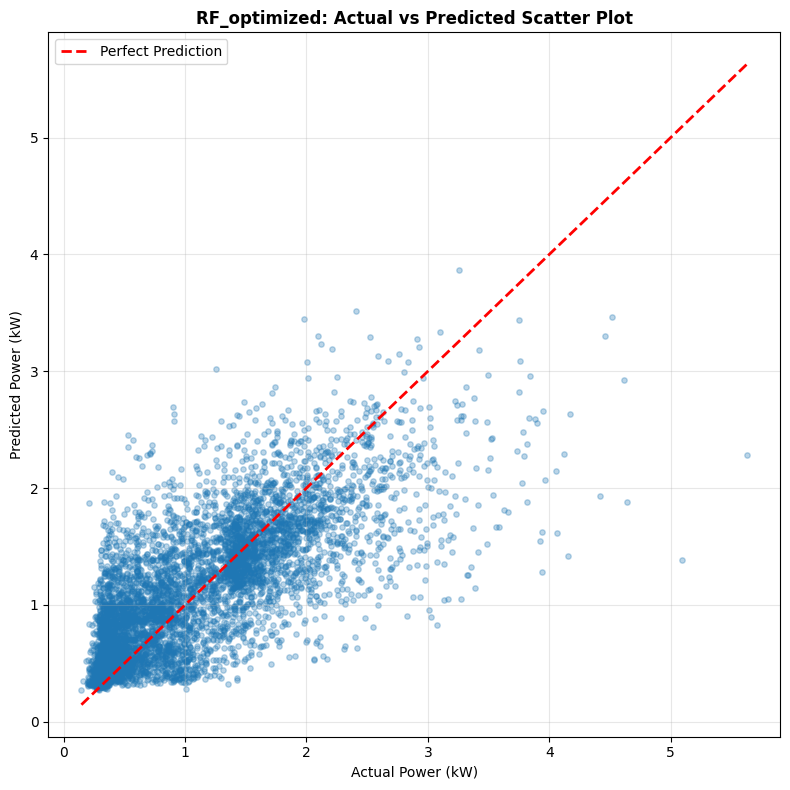

In [270]:
import matplotlib.pyplot as plt
import numpy as np


best_model_name = final_df.sort_values("RMSE").iloc[0]["Model"]


if best_model_name in after_tuning_predictions:
    y_pred_best = after_tuning_predictions[best_model_name]
else:
    y_pred_best = before_tuning_predictions[best_model_name]

plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred_best, alpha=0.3, s=15)


min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())

plt.plot([min_val, max_val],
         [min_val, max_val],
         'r--', lw=2, label='Perfect Prediction')

plt.title(f'{best_model_name}: Actual vs Predicted Scatter Plot',
          fontsize=12, fontweight='bold')

plt.xlabel('Actual Power (kW)')
plt.ylabel('Predicted Power (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


9. FEATURE IMPORTANCE (for tree-based models)


/tmp/ipython-input-3680400003.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importance, y='feature', x='importance', ax=ax1, palette='viridis')


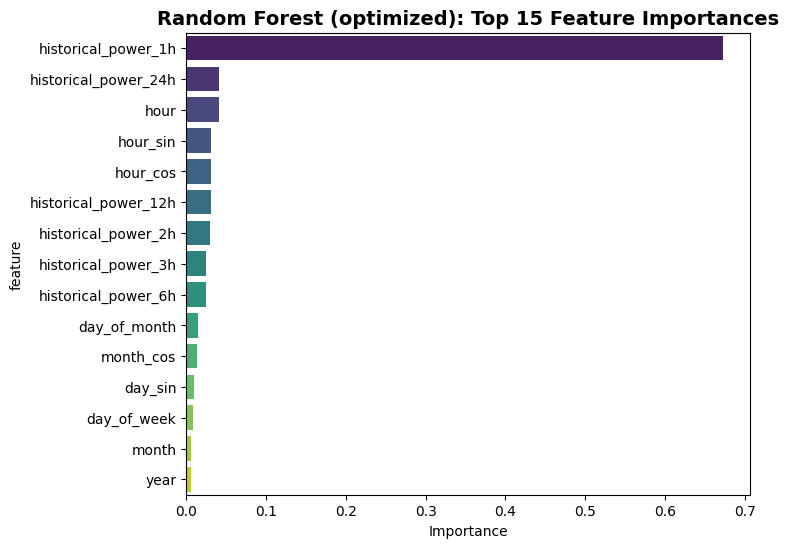

In [277]:
fig = plt.figure(figsize=(16, 6))

# Random Forest feature importance
ax1 = plt.subplot(1, 2, 1)

rf_best = grid_searches["RF_optimized"].best_estimator_

rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False).head(15)

sns.barplot(data=rf_importance, y='feature', x='importance', ax=ax1, palette='viridis')
plt.title('Random Forest (optimized): Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.show()
